# Combine sensor recordings for Berit experiment

In January 10-11, two day experiment on audience experience of operatic singing. 17-19 participants attended each day. First day, opera singer present in room to perform short program (2 songs) live. Second day, video of performance played for second group of participants. 

A combination of devices and recording systems were used to collect physiological measurements from the singer and participants. Most audience members' cardiac information and body sway was recorded via wireless sensors (ECG and EMG with ACC) in the Delsys system. The singer and a few other members of the audiences wore Movesense sensors to capture ECG and sometimes also Heart rate and Linear acceleration, recorded to mobile phones (iphone Movesense app, Android showcase app). Capturing data from the Movesense sensors was less reliable than ideal, and these complications are explored more systematically elsewhere. 

This notebook checks for data quality across the many different recording devices, alignes the recordings to a common concert time and outputs the shared signals in the intervals measured. 

1. gather signals
2. check on them
3. align to common time line (concert zero)

More processing of the signals and combining of data across devices is in another folder.


In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
def tap_cue_align(cue,sig_ex,sig_ID):
    # a function to take a segment of signal and the tapping cue to determing
    # the best shift value would allow alignment of signal to cue
    signal = sig_ex.copy()
        # make the signal excerpt corr compatible. Inclusing cutting the extreme peaks
    signal[signal.isna()] = 0
    M = signal.quantile(0.998)
    signal = signal/M
    signal[signal>1] = 1
    
    # cue must be sampled at the same steady rate as the signal exerpt
    sampleshift_s = cue.index.to_series().diff().median()
    length = np.min([len(signal),len(cue)])
    
    if signal.diff().abs().sum()<0.1: # signal is flat
        shifts.append(np.nan)
        print('sig_ex is too flat.')
        return
    else:
        fig = plt.figure(figsize=(15,6))
        ax1 = plt.subplot(311)
        signal.plot(label=sig_ID,ax=ax1,)
        cue.plot.line(y='cue',ax=ax1)
        ax1.legend()
        #plt.xlim(cue_range)
        
        ax2 = plt.subplot(312)
        CCC = ax2.xcorr(cue['cue'].iloc[:length], signal.iloc[:length], usevlines=True, maxlags=length-1, normed=True, lw=3)
        ax2.grid(True)
        
        signal.index = signal.index + sampleshift_s*CCC[0][np.argmax(CCC[1])]
        
        ax1 = plt.subplot(313)
        signal.plot(label=sig_ID,ax=ax1,)
        cue.plot.line(y='cue',ax=ax1)
#         plt.xlim(cue_range)
        ax1.grid(True)
        #plt.saveas('')
        plt.show()

    shift_stats = {"s_corr0": CCC[1][CCC[0]==0][0], # alignment quality without adjustment,
                   "s_corr_offset": np.amax(CCC[1]),
                   "s_offset_samples": CCC[0][np.argmax(CCC[1])], # shifts
                   "s_offset_time": sampleshift_s*CCC[0][np.argmax(CCC[1])],
                   "Length_xcorr_samples": len(CCC[0]),
                   "Length_xcorr_time": len(CCC[0])*sampleshift_s,
                   "devID": sig_ID,
                   "index_offset":sampleshift_s*CCC[0][np.argmax(CCC[1])],
                   "Full_CCC": CCC

    }
    return shift_stats

## Reorganise data from Delsys

In [3]:
path = '.'
file_locs = []
for root, dirs, files in os.walk(path):
    for file in files:
        if(file.lower().endswith(".csv")): # ignoring the json files for now, those are only from datalogger
            file_locs.append(os.path.join(root,file))
# file_locs

The formating of delsys data is unwheeldy, so we are breaking it up per device and signal, to mirror structure of Movesense recordings

In [5]:
file = './Day1/Delsys_Day1_export.csv'
data = pd.read_csv(file,skiprows=424)
data.iloc[:5,:]

,X [s],Trigno sensor 1: EMG 1 [Volts],X [s].1,Trigno sensor 1: Acc 1.X [g],X [s].2,Trigno sensor 1: Acc 1.Y [g],X [s].3,Trigno sensor 1: Acc 1.Z [g],X [s].4,Trigno sensor 3: EMG 3 [Volts],...,X [s].55,EKG sensor 14: ACC.Y 14 [g],X [s].56,EKG sensor 14: ACC.Z 14 [g],X [s].57,EKG sensor 14: GYRO.X 14 [�/s],X [s].58,EKG sensor 14: GYRO.Y 14 [�/s],X [s].59,EKG sensor 14: GYRO.Z 14 [�/s]
0,0.000000,0.0,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.0,...,0.00000,0.0,0.00000,0.0,0.00000,0.0,0.00000,0.0,0.00000,0.0
1,0.000519,0.0,0.00675,0.000000,0.00675,0.000000,0.00675,0.000000,0.000519,0.0,...,0.00675,0.0,0.00675,0.0,0.00675,0.0,0.00675,0.0,0.00675,0.0
2,0.001038,0.0,0.01350,0.000000,0.01350,0.000000,0.01350,0.000000,0.001038,0.0,...,0.01350,0.0,0.01350,0.0,0.01350,0.0,0.01350,0.0,0.01350,0.0
3,0.001558,0.0,0.02025,0.000000,0.02025,0.000000,0.02025,0.000000,0.001558,0.0,...,0.02025,0.0,0.02025,0.0,0.02025,0.0,0.02025,0.0,0.02025,0.0
4,0.002077,0.0,0.02700,-0.346942,0.02700,0.385491,0.02700,0.578237,0.002077,0.0,...,0.02700,0.0,0.02700,0.0,0.02700,0.0,0.02700,0.0,0.02700,0.0


In [6]:
Delsys_sensors = ['Trigno sensor 1','Trigno sensor 3','Trigno sensor 4','Trigno sensor 5','Trigno Mini sensor 6','Trigno Mini sensor 7','Trigno Mini sensor 8','Trigno Mini sensor 9','EKG sensor 11','EKG sensor 12','EKG sensor 13','EKG sensor 14' ]
Acc_time = data['X [s].1'].dropna()
EMG_time = data['X [s]'].dropna()
EKG_time = data['X [s].53'].dropna()
Acc_sensors=['Trigno sensor 1: Acc 1.X [g]','Trigno sensor 1: Acc 1.Y [g]','Trigno sensor 1: Acc 1.Z [g]','Trigno sensor 3: Acc 3.X [g]','Trigno sensor 3: Acc 3.Y [g]','Trigno sensor 3: Acc 3.Z [g]','Trigno sensor 4: Acc 4.X [g]','Trigno sensor 4: Acc 4.Y [g]','Trigno sensor 4: Acc 4.Z [g]','Trigno sensor 5: Acc 5.X [g]','Trigno sensor 5: Acc 5.Y [g]','Trigno sensor 5: Acc 5.Z [g]','Trigno Mini sensor 6: Acc 6.X [g]','Trigno Mini sensor 6: Acc 6.Y [g]','Trigno Mini sensor 6: Acc 6.Z [g]','Trigno Mini sensor 7: Acc 7.X [g]','Trigno Mini sensor 7: Acc 7.Y [g]','Trigno Mini sensor 7: Acc 7.Z [g]','Trigno Mini sensor 8: Acc 8.X [g]','Trigno Mini sensor 8: Acc 8.Y [g]','Trigno Mini sensor 8: Acc 8.Z [g]','Trigno Mini sensor 9: Acc 9.X [g]','Trigno Mini sensor 9: Acc 9.Y [g]','Trigno Mini sensor 9: Acc 9.Z [g]','EKG sensor 11: ACC.X 11 [g]','EKG sensor 11: ACC.Y 11 [g]','EKG sensor 11: ACC.Z 11 [g]','EKG sensor 12: ACC.X 12 [g]','EKG sensor 12: ACC.Y 12 [g]','EKG sensor 12: ACC.Z 12 [g]','EKG sensor 13: ACC.X 13 [g]','EKG sensor 13: ACC.Y 13 [g]','EKG sensor 13: ACC.Z 13 [g]','EKG sensor 14: ACC.X 14 [g]','EKG sensor 14: ACC.Y 14 [g]','EKG sensor 14: ACC.Z 14 [g]']
Cardiac_sensors = ['Trigno sensor 1: EMG 1 [Volts]','Trigno sensor 3: EMG 3 [Volts]','Trigno sensor 4: EMG 4 [Volts]','Trigno sensor 5: EMG 5 [Volts]','Trigno Mini sensor 6: EMG 6 [Volts]','Trigno Mini sensor 7: EMG 7 [Volts]','Trigno Mini sensor 8: EMG 8 [Volts]','Trigno Mini sensor 9: EMG 9 [Volts]','EKG sensor 11: EKG 11 [V]','EKG sensor 12: EKG 12 [V]','EKG sensor 13: EKG 13 [V]','EKG sensor 14: EKG 14 [V]']

In [7]:
# DAY 1 Delsys signal division
for i in range(len(Delsys_sensors)):
    print(Delsys_sensors[i])
    sig = 'acc'
    dev_cols = [x for x in Acc_sensors if x.startswith(Delsys_sensors[i])] 
    sub_data = pd.DataFrame(index = Acc_time.values, data = data[dev_cols].dropna().values,columns = ['x','y','z'])
    filename = 'Delsys_20230110T120000Z_' + ''.join(Delsys_sensors[i].split(' '))+'_' + sig + '_stream.csv'
    sub_data.to_csv('./Day1/Delsys/' + filename)
    
for i in range(len(Delsys_sensors)):
    sen_ID = Delsys_sensors[i]
    print(sen_ID)
    if sen_ID.startswith('EKG'):
        time = EKG_time
        sig = 'ekg'
    else:
        time = EMG_time
        sig = 'emg'        
    dev_cols = [x for x in Cardiac_sensors if x.startswith(Delsys_sensors[i])] 
    sub_data = pd.DataFrame(index = time.values, data = data[dev_cols].dropna().values,columns = [sig])
    filename = 'Delsys_20230110T120000Z_' + ''.join(Delsys_sensors[i].split(' '))+'_' + sig + '_stream.csv'
    sub_data.to_csv('./Day1/Delsys/' + filename)

Trigno sensor 1
Trigno sensor 3
Trigno sensor 4
Trigno sensor 5
Trigno Mini sensor 6
Trigno Mini sensor 7
Trigno Mini sensor 8
Trigno Mini sensor 9
EKG sensor 11
EKG sensor 12
EKG sensor 13
EKG sensor 14
Trigno sensor 1
Trigno sensor 3
Trigno sensor 4
Trigno sensor 5
Trigno Mini sensor 6
Trigno Mini sensor 7
Trigno Mini sensor 8
Trigno Mini sensor 9
EKG sensor 11
EKG sensor 12
EKG sensor 13
EKG sensor 14


In [8]:
file = './Day2/Delsys_Day2_export.csv'
data = pd.read_csv(file,skiprows=424)
data.iloc[:5,:]

,X [s],Trigno sensor 1: EMG 1 [Volts],X [s].1,Trigno sensor 1: Acc 1.X [g],X [s].2,Trigno sensor 1: Acc 1.Y [g],X [s].3,Trigno sensor 1: Acc 1.Z [g],X [s].4,Trigno sensor 3: EMG 3 [Volts],...,X [s].55,EKG sensor 14: ACC.Y 14 [g],X [s].56,EKG sensor 14: ACC.Z 14 [g],X [s].57,EKG sensor 14: GYRO.X 14 [�/s],X [s].58,EKG sensor 14: GYRO.Y 14 [�/s],X [s].59,EKG sensor 14: GYRO.Z 14 [�/s]
0,0.000000,0.0,0.00000,0.0,0.00000,0.0,0.00000,0.0,0.000000,0.0,...,0.00000,0.0,0.00000,0.0,0.00000,0.0,0.00000,0.0,0.00000,0.0
1,0.000519,0.0,0.00675,0.0,0.00675,0.0,0.00675,0.0,0.000519,0.0,...,0.00675,0.0,0.00675,0.0,0.00675,0.0,0.00675,0.0,0.00675,0.0
2,0.001038,0.0,0.01350,0.0,0.01350,0.0,0.01350,0.0,0.001038,0.0,...,0.01350,0.0,0.01350,0.0,0.01350,0.0,0.01350,0.0,0.01350,0.0
3,0.001558,0.0,0.02025,0.0,0.02025,0.0,0.02025,0.0,0.001558,0.0,...,0.02025,0.0,0.02025,0.0,0.02025,0.0,0.02025,0.0,0.02025,0.0
4,0.002077,0.0,0.02700,0.0,0.02700,0.0,0.02700,0.0,0.002077,0.0,...,0.02700,0.0,0.02700,0.0,0.02700,0.0,0.02700,0.0,0.02700,0.0


In [11]:
Delsys_sensors = ['Trigno sensor 1','Trigno sensor 3','Trigno sensor 4','Trigno sensor 5','Trigno Mini sensor 6','Trigno Mini sensor 7','Trigno Mini sensor 8','Trigno Mini sensor 9','EKG sensor 11','EKG sensor 12','EKG sensor 13','EKG sensor 14' ]
Acc_time = data['X [s].1'].dropna()
EMG_time = data['X [s]'].dropna()
EKG_time = data['X [s].53'].dropna()
Acc_sensors=['Trigno sensor 1: Acc 1.X [g]','Trigno sensor 1: Acc 1.Y [g]','Trigno sensor 1: Acc 1.Z [g]','Trigno sensor 3: Acc 3.X [g]','Trigno sensor 3: Acc 3.Y [g]','Trigno sensor 3: Acc 3.Z [g]','Trigno sensor 4: Acc 4.X [g]','Trigno sensor 4: Acc 4.Y [g]','Trigno sensor 4: Acc 4.Z [g]','Trigno sensor 5: Acc 5.X [g]','Trigno sensor 5: Acc 5.Y [g]','Trigno sensor 5: Acc 5.Z [g]','Trigno Mini sensor 6: Acc 6.X [g]','Trigno Mini sensor 6: Acc 6.Y [g]','Trigno Mini sensor 6: Acc 6.Z [g]','Trigno Mini sensor 7: Acc 7.X [g]','Trigno Mini sensor 7: Acc 7.Y [g]','Trigno Mini sensor 7: Acc 7.Z [g]','Trigno Mini sensor 8: Acc 8.X [g]','Trigno Mini sensor 8: Acc 8.Y [g]','Trigno Mini sensor 8: Acc 8.Z [g]','Trigno Mini sensor 9: Acc 9.X [g]','Trigno Mini sensor 9: Acc 9.Y [g]','Trigno Mini sensor 9: Acc 9.Z [g]','EKG sensor 11: ACC.X 11 [g]','EKG sensor 11: ACC.Y 11 [g]','EKG sensor 11: ACC.Z 11 [g]','EKG sensor 12: ACC.X 12 [g]','EKG sensor 12: ACC.Y 12 [g]','EKG sensor 12: ACC.Z 12 [g]','EKG sensor 13: ACC.X 13 [g]','EKG sensor 13: ACC.Y 13 [g]','EKG sensor 13: ACC.Z 13 [g]','EKG sensor 14: ACC.X 14 [g]','EKG sensor 14: ACC.Y 14 [g]','EKG sensor 14: ACC.Z 14 [g]']
Cardiac_sensors = ['Trigno sensor 1: EMG 1 [Volts]','Trigno sensor 3: EMG 3 [Volts]','Trigno sensor 4: EMG 4 [Volts]','Trigno sensor 5: EMG 5 [Volts]','Trigno Mini sensor 6: EMG 6 [Volts]','Trigno Mini sensor 7: EMG 7 [Volts]','Trigno Mini sensor 8: EMG 8 [Volts]','Trigno Mini sensor 9: EMG 9 [Volts]','EKG sensor 11: EKG 11 [V]','EKG sensor 12: EKG 12 [V]','EKG sensor 13: EKG 13 [V]','EKG sensor 14: EKG 14 [V]']

In [12]:
# DAY 2 Delsys signal division
for i in range(len(Delsys_sensors)):
    print(Delsys_sensors[i])
    sig = 'acc'
    dev_cols = [x for x in Acc_sensors if x.startswith(Delsys_sensors[i])] 
    sub_data = pd.DataFrame(index = Acc_time.values, data = data[dev_cols].dropna().values,columns = ['x','y','z'])
    filename = 'Delsys_20230111T120000Z_' + ''.join(Delsys_sensors[i].split(' '))+'_' + sig + '_stream.csv'
    sub_data.to_csv('./Day2/Delsys/' + filename)

for i in range(len(Delsys_sensors)):
    sen_ID = Delsys_sensors[i]
    print(sen_ID)
    if sen_ID.startswith('EKG'):
        time = EKG_time
        sig = 'ekg'
    else:
        time = EMG_time
        sig = 'emg'        
    dev_cols = [x for x in Cardiac_sensors if x.startswith(Delsys_sensors[i])] 
    sub_data = pd.DataFrame(index = time.values, data = data[dev_cols].dropna().values,columns = [sig])
    filename = 'Delsys_20230111T120000Z_' + ''.join(Delsys_sensors[i].split(' '))+'_' + sig + '_stream.csv'
    sub_data.to_csv('./Day2/Delsys/' + filename)

Trigno sensor 1
Trigno sensor 3
Trigno sensor 4
Trigno sensor 5
Trigno Mini sensor 6
Trigno Mini sensor 7
Trigno Mini sensor 8
Trigno Mini sensor 9
EKG sensor 11
EKG sensor 12
EKG sensor 13
EKG sensor 14
Trigno sensor 1
Trigno sensor 3
Trigno sensor 4
Trigno sensor 5
Trigno Mini sensor 6
Trigno Mini sensor 7
Trigno Mini sensor 8
Trigno Mini sensor 9
EKG sensor 11
EKG sensor 12
EKG sensor 13
EKG sensor 14


# Define tapping cue template
Devices start at different time, record timestamps using their own clocks, and at their own sample rates. All device recordings should feature acceleration (and other signal) bumps at the time of the tapping synch cue. A tapping template is constructed and resampled to fit each signal to determine the timing of concert time zero across devices. 

The tapping cue template is constructed from the timing of beeps and taps according to an audio recording of the experiment. The cue is shaped from beep onset timings and smoothing to correlate reliably with absolute jerk of taps (norm of first order difference on 3D acc signals).

Got the events from the video for taps timing.
    Film_meland_hele_events.csv
Though it is missing the timing of the second baseline recordings. I guess I get to estimate those from the accelerometer readings across devices. 

In [14]:
concert_times = pd.read_csv('Film_meland_hele_events.csv',",") #SV alignment for beeps
concert_times['S_AudioTime'] = 2*np.round(concert_times["TIME"]/2,3) # reset to 50 hz
concert_times['event'] = concert_times["LABEL"]
concert_times['CTime'] = concert_times['S_AudioTime']-concert_times.loc[6,'S_AudioTime'] # zero on onset of first synch cue
concert_times.iloc[:7]

,TIME,Label,S_AudioTime,event,CTime
0,64.476667,Demo tap,64.476,Demo tap,-20.420
1,65.473333,Demo tap,65.474,Demo tap,-19.422
2,66.476667,Demo tap,66.476,Demo tap,-18.420
3,81.890000,Beep 1,81.890,Beep 1,-3.006
4,82.890000,Beep 1,82.890,Beep 1,-2.006
5,83.896667,Beep 1,83.896,Beep 1,-1.000
6,84.896000,Concert Zero,84.896,Concert Zero,0.000


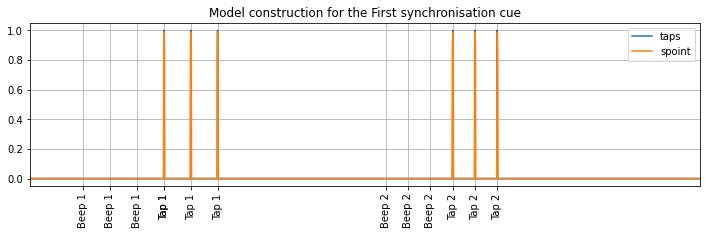

In [15]:
t_range = [-5, 25]
# cues for synchronisation taps
cues = pd.DataFrame(index = np.round(np.arange(0,t_range[1]-t_range[0],0.01)-5,2))
sampleshift = 0.01
np.round(np.arange(0,30,0.01)-5,3) 

cues['taps'] = 0
cues.loc[np.round(concert_times.loc[7,"CTime"],2),'taps'] = 1
cues.loc[np.round(concert_times.loc[8,"CTime"],2),'taps'] = 1
cues.loc[np.round(concert_times.loc[9,"CTime"],2),'taps'] = 1
cues.loc[np.round(concert_times.loc[13,"CTime"],2),'taps'] = 1
cues.loc[np.round(concert_times.loc[14,"CTime"],2),'taps'] = 1
cues.loc[np.round(concert_times.loc[15,"CTime"],2),'taps'] = 1
cues['spoint'] = cues['taps'].rolling(4, win_type='gaussian', center=True).sum(std=3)#.ewm(span = 5).mean()
cues[cues.isna()] = 0

Cue_template = cues.copy()
Cue_template.plot(figsize = [12,3]) # 2 is nice
plt.xticks(concert_times.CTime,concert_times.event, rotation='vertical')
plt.grid()
plt.xlim([-5,20])
plt.title('Model construction for the First synchronisation cue')
plt.savefig('synch1_cues.png')
plt.show()

Cue_template.to_csv('Synch_Cue_template_100Hz.csv')

# Identify synch timing in each device's time
Need to evaluate times in 

- Delsys Day 2
- Kayla's phone day 2
- Jonna's phone, day 2

- Delsys Day 1
- Kayla's phone day 1
- estimate singer's timing on day 1 based on difference in timing off set between Kayla and Jonna's phone on day 2.

Starting on day 2 because initial evaluation of tap timings on day 1 yeilded some surprising results. 

## Delsys day 2

First identify ideal tapping offset from accelerometer measurements. The Delsys records the fleet of sensors with the same start time and clock, so we can take the offset from the median across all measurements taken.

In [16]:
path = './Day2/Delsys/'
file_locs = []
for root, dirs, files in os.walk(path):
    for file in files:
        if(file.lower().endswith(".csv")): # ignoring the json files for now, those are only from datalogger
            file_locs.append(os.path.join(root,file))

acc_locs = [x for x in file_locs if x.endswith('acc_stream.csv')] 
print(acc_locs)

acc_day = pd.DataFrame()
for file in acc_locs:
    sig_df = pd.read_csv(file,index_col=0)
    sensorID = file.split('_')[2]
    V = sig_df.loc[:,['x','y','z']].copy()
    X=np.sqrt(np.square(V.diff()).sum(axis=1))
    acc_day[sensorID] = X
acc_day.iloc[:5,:]

['./Day2/Delsys/Delsys_20230111T120000Z_EKGsensor12_acc_stream.csv', './Day2/Delsys/Delsys_20230111T120000Z_EKGsensor14_acc_stream.csv', './Day2/Delsys/Delsys_20230111T120000Z_Trignosensor1_acc_stream.csv', './Day2/Delsys/Delsys_20230111T120000Z_EKGsensor13_acc_stream.csv', './Day2/Delsys/Delsys_20230111T120000Z_EKGsensor11_acc_stream.csv', './Day2/Delsys/Delsys_20230111T120000Z_Trignosensor4_acc_stream.csv', './Day2/Delsys/Delsys_20230111T120000Z_Trignosensor3_acc_stream.csv', './Day2/Delsys/Delsys_20230111T120000Z_Trignosensor5_acc_stream.csv', './Day2/Delsys/Delsys_20230111T120000Z_TrignoMinisensor9_acc_stream.csv', './Day2/Delsys/Delsys_20230111T120000Z_TrignoMinisensor6_acc_stream.csv', './Day2/Delsys/Delsys_20230111T120000Z_TrignoMinisensor7_acc_stream.csv', './Day2/Delsys/Delsys_20230111T120000Z_TrignoMinisensor8_acc_stream.csv']


,EKGsensor12,EKGsensor14,Trignosensor1,EKGsensor13,EKGsensor11,Trignosensor4,Trignosensor3,Trignosensor5,TrignoMinisensor9,TrignoMinisensor6,TrignoMinisensor7,TrignoMinisensor8
0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.00675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.01350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.02025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.02700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

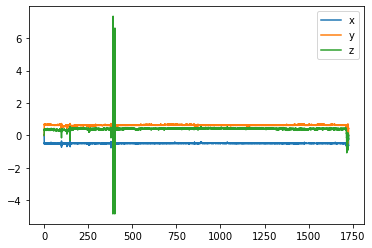

In [17]:
# first find tapping timing in one acc recording from delsys
file = acc_locs[2]
sig_df = pd.read_csv(file,index_col=0)
sensorID = file.split('_')[2]
sig_df.plot() 

From a test plot of the whole acc signal, estimate the timing of the tapping cue in device time stamp values. Set this as initial_offset and iterate a few times to get this right to the correct offset time within tolerance. For this study we are getting aligning to within 100 ms, the best we can count on for the parallel recordings in the Movesense. 

In [18]:
initial_offset = 389.02 # approx offset of cue and signal 

4443
4443


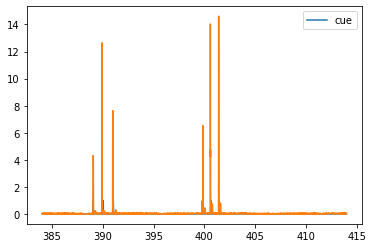

In [19]:
cues = Cue_template.copy()
cues['time_concert'] = cues.index
cues['DeviceTime'] = cues.index + initial_offset
cues.set_index('DeviceTime',inplace=True)

V = sig_df.loc[:,['x','y','z']].copy()
X=np.sqrt(np.square(V.diff()).sum(axis=1))
sig_ex = X.loc[cues.index[0]:cues.index[-1]]
print(len(sig_ex))
sig_ID = sensorID
cuetype = 'spoint'

f = interpolate.interp1d(cues.index, cues[cuetype],fill_value='extrapolate')
cued = pd.DataFrame(index = sig_ex.index,data = f(np.array(sig_ex.index)),columns = ['cue'])
f = interpolate.interp1d(cues.index, cues['time_concert'],fill_value='extrapolate')
cued['time_concert'] = f(np.array(sig_ex.index))
print(len(cued))

cued.plot.line(y = 'cue')
sig_ex.plot()
plt.show()

This degree of alignment is within the range that can be fine tuned by the cross correlation if necessary. Because delsys has all the acc recordings on the same device time, we won't be adjusting individual sensor recordings from their respective suggested offsets.

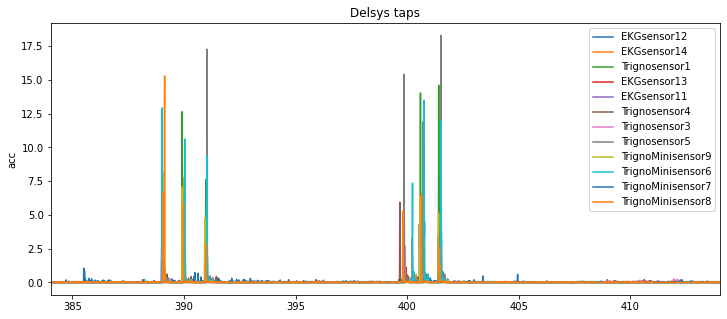

In [20]:
fig = plt.figure(figsize=(12,5))
acc_day = pd.DataFrame()
for file in acc_locs:
    sig_df = pd.read_csv(file,index_col=0)
    sensorID = file.split('_')[2]
    V = sig_df.loc[:,['x','y','z']].copy()
    X=np.sqrt(np.square(V.diff()).sum(axis=1))
    X.plot(label=sensorID)
    acc_day[sensorID] = X
plt.legend()
plt.ylabel('acc')
plt.title('Delsys taps')
#plt.ylim([0,1000])
plt.xlim([initial_offset -5 ,initial_offset + 25])
plt.show()

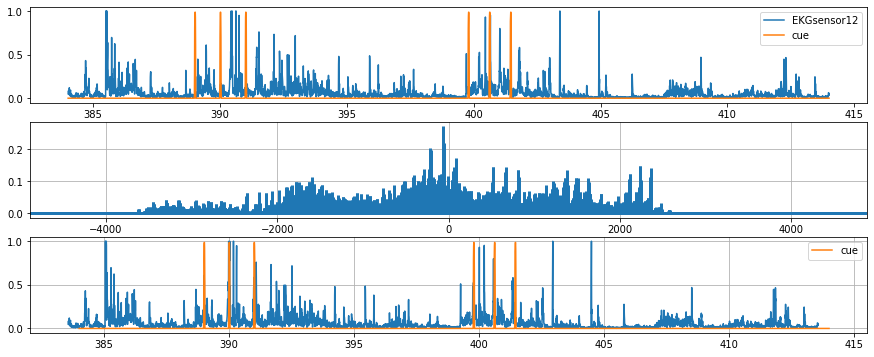

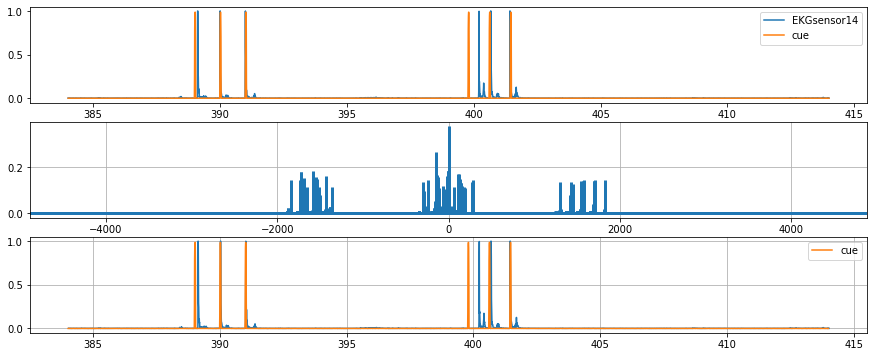

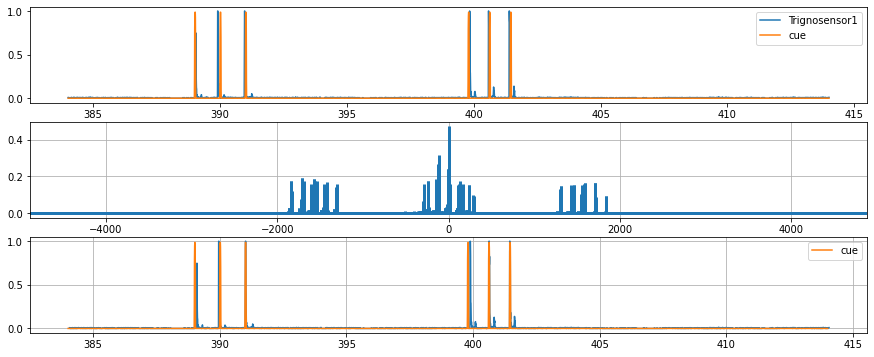

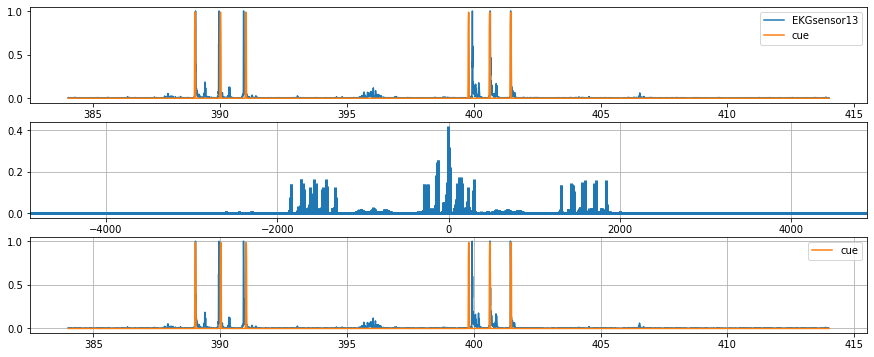

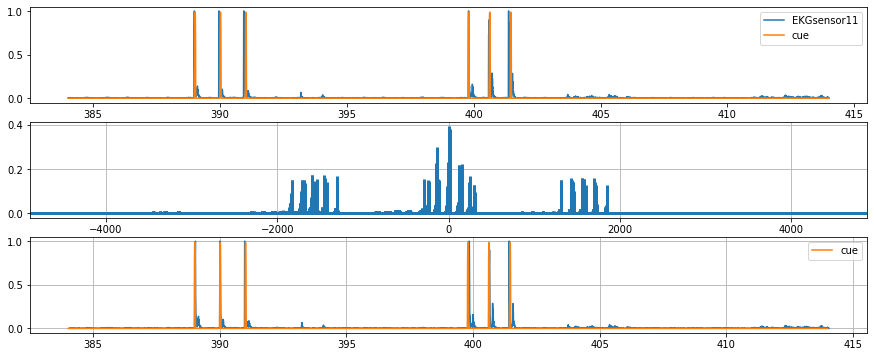

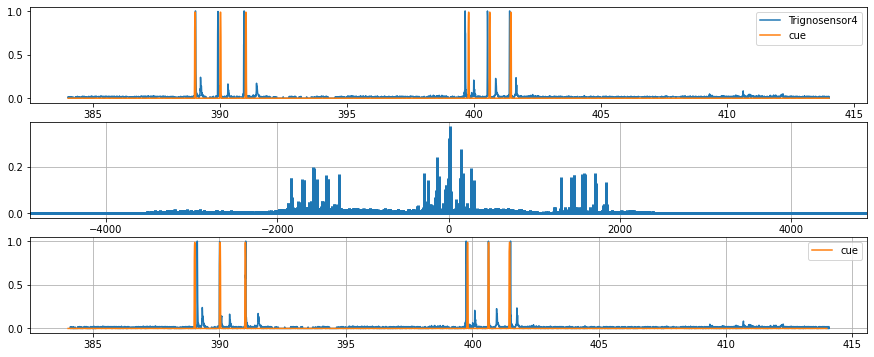

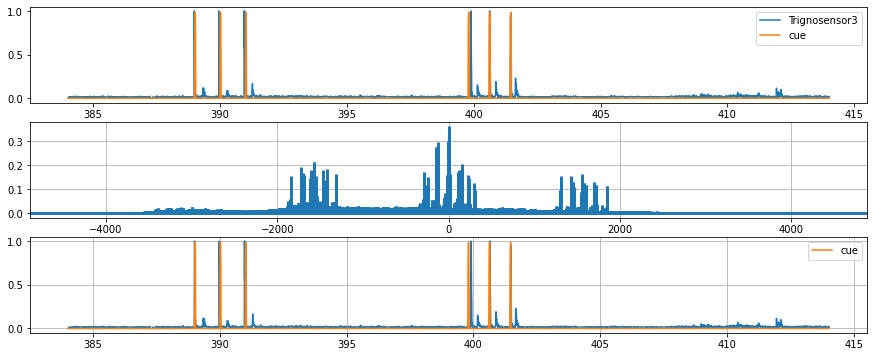

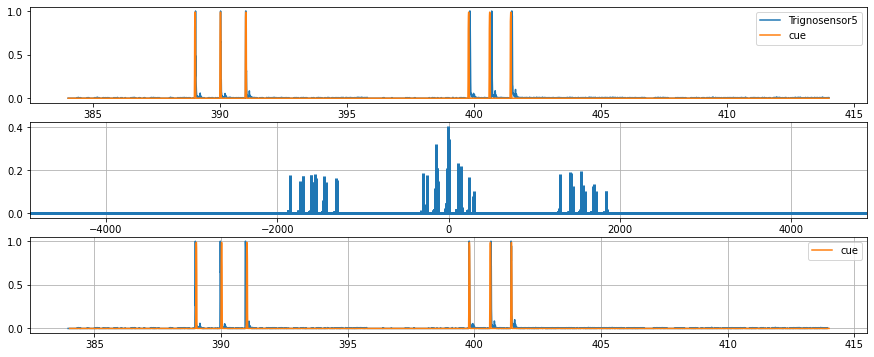

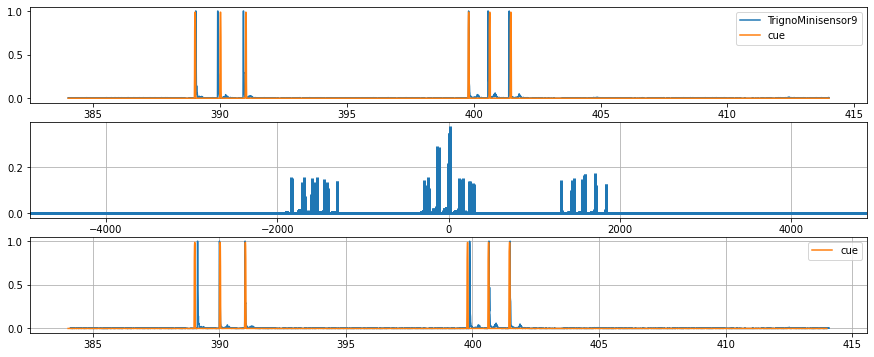

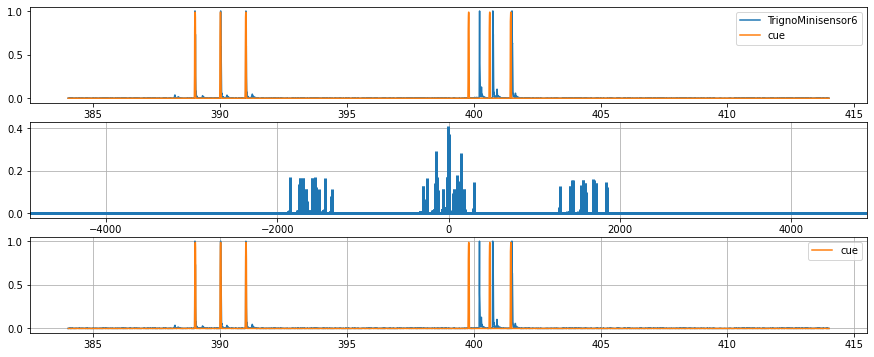

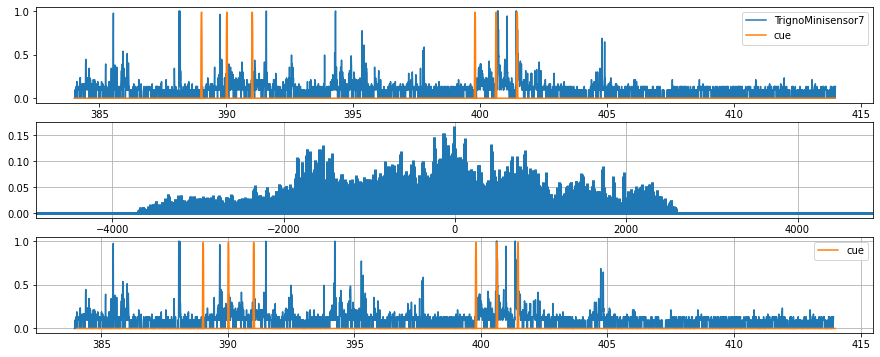

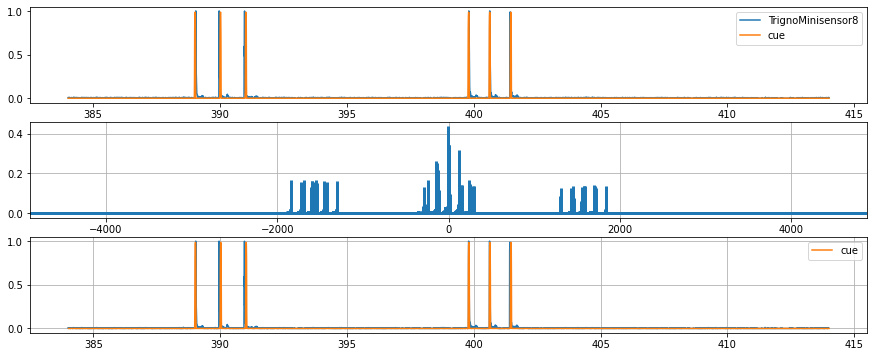

In [21]:
sig_exs = acc_day.loc[cued.index[0]:cued.index[-1]]
cols = sig_exs.columns
shifts = []
for c in cols:
    shifts.append(tap_cue_align(cued,sig_exs[c],c))

In [22]:
shift_df = pd.DataFrame.from_records(shifts)
print(shift_df['s_offset_time'].median())
shift_df

0.003500000000002501


,s_corr0,s_corr_offset,s_offset_samples,s_offset_time,Length_xcorr_samples,Length_xcorr_time,devID,index_offset,Full_CCC
0,0.077403,0.272790,-63,-0.441,8885,62.195,EKGsensor12,-0.441,"([-4442, -4441, -4440, -4439, -4438, -4437, -4..."
1,0.266689,0.379913,3,0.021,8885,62.195,EKGsensor14,0.021,"([-4442, -4441, -4440, -4439, -4438, -4437, -4..."
2,0.050407,0.472996,7,0.049,8885,62.195,Trignosensor1,0.049,"([-4442, -4441, -4440, -4439, -4438, -4437, -4..."
3,0.320270,0.418502,-2,-0.014,8885,62.195,EKGsensor13,-0.014,"([-4442, -4441, -4440, -4439, -4438, -4437, -4..."
4,0.260051,0.394462,7,0.049,8885,62.195,EKGsensor11,0.049,"([-4442, -4441, -4440, -4439, -4438, -4437, -4..."
5,0.112147,0.373685,12,0.084,8885,62.195,Trignosensor4,0.084,"([-4442, -4441, -4440, -4439, -4438, -4437, -4..."
6,0.329068,0.363304,2,0.014,8885,62.195,Trignosensor3,0.014,"([-4442, -4441, -4440, -4439, -4438, -4437, -4..."
7,0.344108,0.403950,-8,-0.056,8885,62.195,Trignosensor5,-0.056,"([-4442, -4441, -4440, -4439, -4438, -4437, -4..."
8,0.152588,0.379592,12,0.084,8885,62.195,TrignoMinisensor9,0.084,"([-4442, -4441, -4440, -4439, -4438, -4437, -4..."
9,0.372223,0.409512,-1,-0.007,8885,62.195,TrignoMinisensor6,-0.007,"([-4442, -4441, -4440, -4439, -4438, -4437, -4..."


The cross correlation results show that this initial_offset value is within tolerance, so we output the signal recordings with concert time instead of device time. 

In [23]:
V = acc_day.copy()
V.set_index(acc_day.index-initial_offset,inplace = True)
V.to_csv('./Day2/Timed/Delsys_acc_Day2.csv')

We have the delsys day 2 offset down to less than 10 ms. Pretty good.

## Output other signals from this system in concert time


In [34]:
path = './Day2/Delsys/'
sig = 'ekg'
file_locs = []
for root, dirs, files in os.walk(path):
    for file in files:
        if(file.lower().endswith(".csv")): # ignoring the json files for now, those are only from datalogger
            file_locs.append(os.path.join(root,file))

sig_locs = [x for x in file_locs if x.endswith(sig + '_stream.csv')] 
sig_locs

['./Day2/Delsys/Delsys_20230111T120000Z_EKGsensor11_ekg_stream.csv',
 './Day2/Delsys/Delsys_20230111T120000Z_EKGsensor13_ekg_stream.csv',
 './Day2/Delsys/Delsys_20230111T120000Z_EKGsensor14_ekg_stream.csv',
 './Day2/Delsys/Delsys_20230111T120000Z_EKGsensor12_ekg_stream.csv']

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


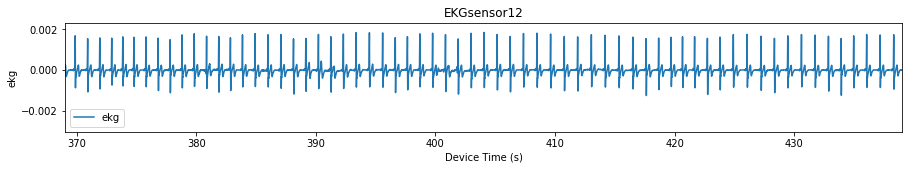

In [37]:
file = sig_locs[3]#'./Day1/Delsys/Delsys_20230110T120000Z_Trignosensor1_acc_stream.csv'
sig_df = pd.read_csv(file,index_col=0)
sensorID = file.split('_')[2]
sig_df 

sig_df.plot(figsize=(15,2))
plt.ylabel(sig)
plt.title(sensorID)
#plt.ylim([0,1000])
plt.xlim([initial_offset - 20,initial_offset + 50])
plt.xlabel('Device Time (s)')
plt.show()

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


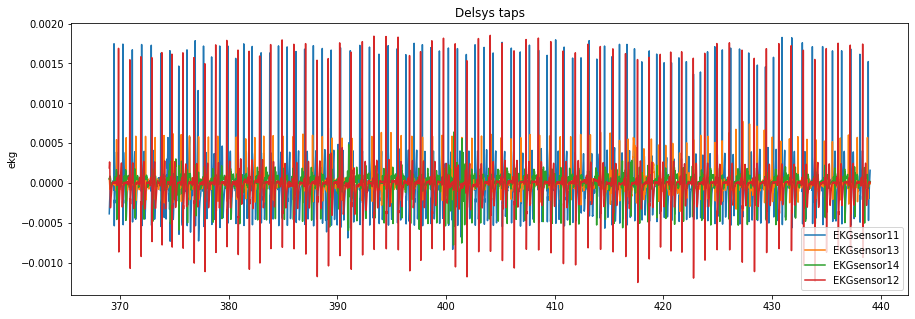

In [27]:
#fig = plt.figure()
sig_day = pd.DataFrame(index = sig_df.index)
for file in sig_locs:
    sig_df = pd.read_csv(file,index_col=0)
    sensorID = file.split('_')[2]
    sig_day[sensorID] = sig_df
sig_day.loc[(initial_offset - 20):(initial_offset + 50),:].plot(figsize=(15,5))
plt.legend()
plt.ylabel(sig)
plt.title('Delsys taps')
plt.show()

In [28]:
sig_day.iloc[:5,:]

V = sig_day.copy()
# V['DeviceTime'] = acc_day1.index
V.set_index(sig_day.index-initial_offset,inplace = True)
V.to_csv('./Day2/Timed/Delsys_ekg_Day2.csv')

In [38]:
path = './Day2/Delsys/'
sig = 'emg'
file_locs = []
for root, dirs, files in os.walk(path):
    for file in files:
        if(file.lower().endswith(".csv")): # ignoring the json files for now, those are only from datalogger
            file_locs.append(os.path.join(root,file))

sig_locs = [x for x in file_locs if x.endswith(sig + '_stream.csv')] 
sig_locs

['./Day2/Delsys/Delsys_20230111T120000Z_TrignoMinisensor8_emg_stream.csv',
 './Day2/Delsys/Delsys_20230111T120000Z_TrignoMinisensor7_emg_stream.csv',
 './Day2/Delsys/Delsys_20230111T120000Z_TrignoMinisensor6_emg_stream.csv',
 './Day2/Delsys/Delsys_20230111T120000Z_TrignoMinisensor9_emg_stream.csv',
 './Day2/Delsys/Delsys_20230111T120000Z_Trignosensor1_emg_stream.csv',
 './Day2/Delsys/Delsys_20230111T120000Z_Trignosensor5_emg_stream.csv',
 './Day2/Delsys/Delsys_20230111T120000Z_Trignosensor3_emg_stream.csv',
 './Day2/Delsys/Delsys_20230111T120000Z_Trignosensor4_emg_stream.csv']

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


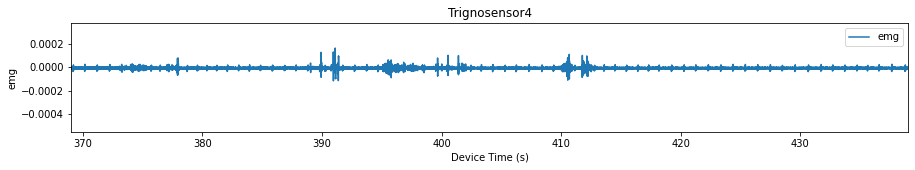

In [44]:
file = sig_locs[7]#'./Day1/Delsys/Delsys_20230110T120000Z_Trignosensor1_acc_stream.csv'
sig_df = pd.read_csv(file,index_col=0)
sensorID = file.split('_')[2]
sig_df 

sig_df.plot(figsize=(15,2))
plt.ylabel(sig)
plt.title(sensorID)
#plt.ylim([0,1000])
plt.xlim([initial_offset - 20,initial_offset + 50])
plt.xlabel('Device Time (s)')
plt.show()

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


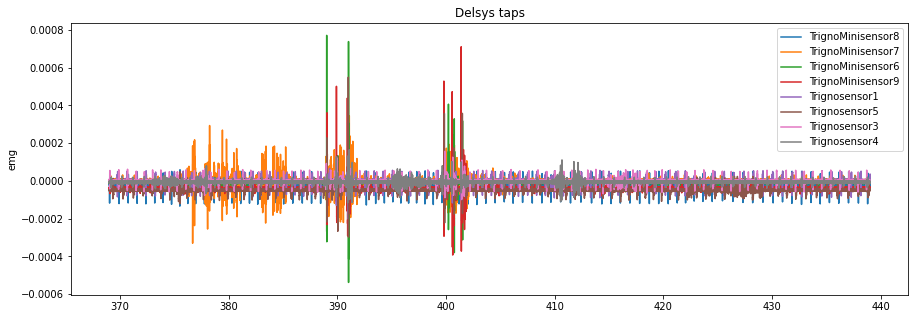

In [31]:
#fig = plt.figure()
sig_day = pd.DataFrame(index = sig_df.index)
for file in sig_locs:
    sig_df = pd.read_csv(file,index_col=0)
    sensorID = file.split('_')[2]
    sig_day[sensorID] = sig_df
sig_day.loc[(initial_offset - 20):(initial_offset + 50),:].plot(figsize=(15,5))
plt.legend()
plt.ylabel(sig)
plt.title('Delsys taps')
plt.show()

In [32]:
sig_day.iloc[:5,:]

V = sig_day.copy()
# V['DeviceTime'] = acc_day1.index
V.set_index(sig_day.index-initial_offset,inplace = True)
V.to_csv('./Day2/Timed/Delsys_emg_Day2.csv')

# Day 2 Movesense

The movesense devices that were connected continuously to the iPhone App recorded several signals at once, but all in separate files. Even though some devices were recorded via the same phone, the timestamps were not shared. Each sensor unit logged time by its own clock.

There were also some signals that were lost due to app malfunction (Laura's phone). Testing of android app recordings of the movesense were taken on non-participants to avoid the datalosses of the previous experiment day. 

In [99]:
#data_loc = './Day2/Movesense_iPhone_Jonna/'
data_loc = './Day2/Movesense_iPhone_Kayla/'
sig = 'acc'
files = os.listdir(data_loc)
k = []
for f in files:
    if f.endswith('.csv'):
        c = f.split('_')
        st = dt.datetime.strptime(c[0][:-1],'%Y%m%dT%H%M%S')
        devID = int(c[1])
        fl = {'Signal':c[2],'StartTime':st,'daytime':int(c[0][9:15]),'date':int(c[0][:8]),'Device':devID,'File':f}
        k.append(fl)
df_files=pd.DataFrame(data=k).sort_values('StartTime').reset_index(drop=True)
df_files

,Signal,StartTime,daytime,date,Device,File
0,ecg,2023-01-11 11:45:44,114544,20230111,223130000551,20230111T114544Z_223130000551_ecg_stream.csv
1,acc,2023-01-11 11:45:44,114544,20230111,223130000551,20230111T114544Z_223130000551_acc_stream.csv
2,ecg,2023-01-11 11:45:44,114544,20230111,223130000510,20230111T114544Z_223130000510_ecg_stream.csv
3,heartRate,2023-01-11 11:45:44,114544,20230111,223130000510,20230111T114544Z_223130000510_heartRate_stream...
4,heartRate,2023-01-11 11:45:44,114544,20230111,223130000551,20230111T114544Z_223130000551_heartRate_stream...
5,acc,2023-01-11 11:45:44,114544,20230111,223130000510,20230111T114544Z_223130000510_acc_stream.csv


In [100]:
df_files.Device.unique() #  223130000541, 223130000551, 223130000510

array([223130000551, 223130000510])

No advantage to processing measurements from different devices on same phone becaust the time stamps are specific to each device. So instead we get the lags for one devices from the ACC and generate the concert time files for the other signals with the same device. 

In [105]:
sensorID = 223130000510
sens_files = df_files.loc[df_files['Device']==sensorID,:]
acc_file = sens_files.loc[sens_files['Signal']=='acc','File'].values[0]
print(acc_file)
sens_files

20230111T114544Z_223130000510_acc_stream.csv


,Signal,StartTime,daytime,date,Device,File
2,ecg,2023-01-11 11:45:44,114544,20230111,223130000510,20230111T114544Z_223130000510_ecg_stream.csv
3,heartRate,2023-01-11 11:45:44,114544,20230111,223130000510,20230111T114544Z_223130000510_heartRate_stream...
5,acc,2023-01-11 11:45:44,114544,20230111,223130000510,20230111T114544Z_223130000510_acc_stream.csv


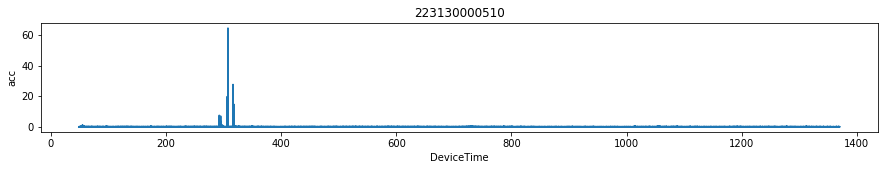

In [106]:
sig_df = pd.read_csv(data_loc + acc_file)
sig_df.rename(columns={"timestamp": "DeviceStamps"},inplace=True)
sig_df['DeviceTime'] = sig_df['DeviceStamps']/1000
sig_df.set_index('DeviceTime',inplace=True)
V = sig_df.loc[:,['x','y','z']].copy()
X=np.sqrt(np.square(V.diff()).sum(axis=1))
X.plot(figsize=(15,2))
plt.ylabel(sig)
plt.title(sensorID)
plt.show()

In [49]:
initial_offset = 306

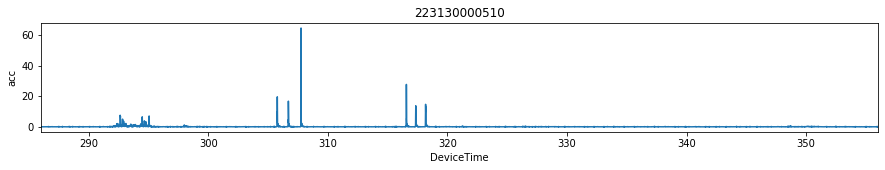

In [50]:
V = sig_df.loc[:,['x','y','z']].copy()
X=np.sqrt(np.square(V.diff()).sum(axis=1))
X.plot(figsize=(15,2))
plt.ylabel(sig)
plt.title(sensorID)
plt.xlim([initial_offset - 20,initial_offset + 50])
plt.show()

In [51]:
cues = Cue_template.copy()
cues['time_concert'] = cues.index
cues['DeviceTime'] = cues.index + initial_offset
cues.set_index('DeviceTime',inplace=True)

V = sig_df.loc[:,['x','y','z']].copy()
X=np.sqrt(np.square(V.diff()).sum(axis=1))
sig_ex = X.loc[cues.index[0]:cues.index[-1]]
print(len(sig_ex))
sig_ID = sensorID
cuetype = 'spoint'

f = interpolate.interp1d(cues.index, cues[cuetype],fill_value='extrapolate')
cued = pd.DataFrame(index = sig_ex.index,data = f(np.array(sig_ex.index)),columns = ['cue'])
f = interpolate.interp1d(cues.index, cues['time_concert'],fill_value='extrapolate')
cued['time_concert'] = f(np.array(sig_ex.index))
print(len(cued))

# cued.plot.line(y = 'cue')
# sig_ex.plot()
# plt.show()

3173
3173


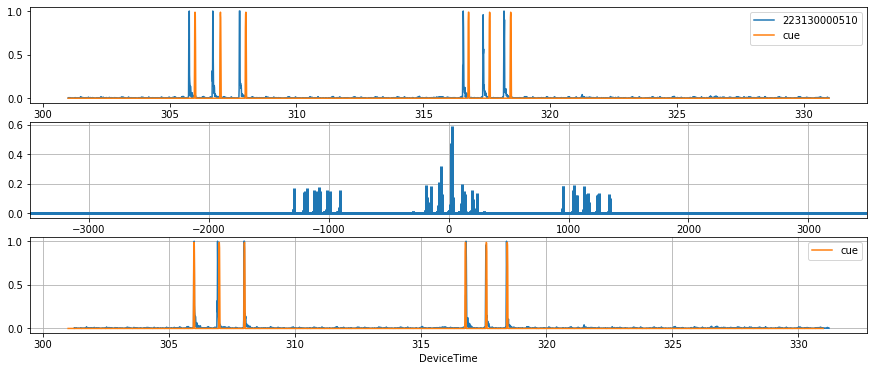

0.23400000000037835

In [52]:
shifts = tap_cue_align(cued,sig_ex,sig_ID)
shifts['s_offset_time']

We are working on the alignment suggested from a single set of taps, not multiple recordings like delsys. This means we need to monitor for misalignments in the crosscorrelation, when noise in the recording or poor tapping results in an alternate alignment to correlate more strongly. These cases are usually easy to spot, but must be compensated for from the information saved in the shifts values.

In this case (sensorID = 223130000510) the cue template correlates extremely well, giving a clean shift to the offset.

In [53]:
offset = initial_offset - np.round(shifts['s_offset_time'],3) # improved alignment of bigining of taps in device time
delay = np.round(offset-sig_df.index[0],3) # time after initial recording of the taps 
print([offset,delay])

[305.766, 256.951]


We calculate here both the offset from device time to concert time and the delay between recording onset and tapping onset for faciliate comparison between phone recordings. Only the offset is needed to produce new files generally. This is used to generate concert time aligned recordings for each of the signal files for that device's recordings

In [54]:
sens_files

,Signal,StartTime,daytime,date,Device,File
2,ecg,2023-01-11 11:45:44,114544,20230111,223130000510,20230111T114544Z_223130000510_ecg_stream.csv
3,heartRate,2023-01-11 11:45:44,114544,20230111,223130000510,20230111T114544Z_223130000510_heartRate_stream...
5,acc,2023-01-11 11:45:44,114544,20230111,223130000510,20230111T114544Z_223130000510_acc_stream.csv


In [55]:
# if the indexes look horrid, re run with the rounding on ConcertTime
for f in sens_files['File']:
    sig_df = pd.read_csv(data_loc + f)
    if f.endswith('heartRate_stream.csv'):
        sig_df['RecTime'] = sig_df['rrData'].cumsum()/1000
        sig_df['ConcertTime'] = np.round(sig_df['RecTime'] - delay,3)
        sig_df.set_index('ConcertTime',inplace=True)
        sig_df.to_csv('./Day2/Timed/' + f)
    else:
        sig_df.rename(columns={"timestamp": "DeviceStamps"},inplace=True)
        sig_df['DeviceTime'] = sig_df['DeviceStamps']/1000
        sig_df['ConcertTime'] = np.round(sig_df['DeviceTime'] - offset,3)
        sig_df.set_index('ConcertTime',inplace=True)
        sig_df.to_csv('./Day2/Timed/' + f)
sig_df.iloc[:5,:]

,DeviceStamps,x,y,z,DeviceTime
ConcertTime,,,,,
-256.951,48815,-0.004786,9.248589,3.211283,48.815
-256.942,48824,0.011965,9.260554,3.204104,48.824
-256.933,48833,-0.021536,9.248589,3.192139,48.833
-256.923,48843,0.002393,9.253376,3.189746,48.843
-256.914,48852,-0.021536,9.255769,3.216068,48.852


note: Kayla devices (223130000510, 223130000551) recorded from 2023-01-11 11:45:44, and caught synch taps on a delay of 257.185, or at 11:50:01
 
Jonna's device (223130000541) recorded from 2023-01-11 11:40:01 and caught taps on delay of 599.694 (10 minutes), rounding to 11:50:01 for synch cue taps. 

This suggests iphones time can be used to sync to the second (ish) so we will use Kayla's delay on Day 1 to set the delay for the singer. 

# Day 1 movesense
There are only two of these that we can sync so. 

But we do want to difference in time between Kayla's phone and Jonna's phone

In [56]:
data_loc = './Day1/Movesense_iPhone/'
sig = 'acc'
files = os.listdir(data_loc)
k = []
for f in files:
    if f.endswith('.csv'):
        c = f.split('_')
        st = dt.datetime.strptime(c[0][:-1],'%Y%m%dT%H%M%S')
        devID = int(c[1])
        fl = {'Signal':c[2],'StartTime':st,'daytime':int(c[0][9:15]),'date':int(c[0][:8]),'Device':devID,'File':f}
        k.append(fl)
df_files=pd.DataFrame(data=k).sort_values('StartTime').reset_index(drop=True)
df_files

,Signal,StartTime,daytime,date,Device,File
0,heartRate,2023-01-10 11:45:02,114502,20230110,223130000620,20230110T114502Z_223130000620_heartRate_stream...
1,acc,2023-01-10 11:45:02,114502,20230110,223130000620,20230110T114502Z_223130000620_acc_stream.csv
2,acc,2023-01-10 11:45:02,114502,20230110,223130000593,20230110T114502Z_223130000593_acc_stream.csv
3,ecg,2023-01-10 11:45:02,114502,20230110,223130000593,20230110T114502Z_223130000593_ecg_stream.csv
4,heartRate,2023-01-10 11:45:02,114502,20230110,223130000593,20230110T114502Z_223130000593_heartRate_stream...
5,ecg,2023-01-10 11:45:02,114502,20230110,223130000620,20230110T114502Z_223130000620_ecg_stream.csv


In [57]:
df_files.Device.unique()

array([223130000620, 223130000593])

In [58]:
sensorID =  223130000593
sens_files = df_files.loc[df_files['Device']==sensorID,:]
acc_file = sens_files.loc[sens_files['Signal']=='acc','File'].values[0]
print(acc_file)
sens_files

20230110T114502Z_223130000593_acc_stream.csv


,Signal,StartTime,daytime,date,Device,File
2,acc,2023-01-10 11:45:02,114502,20230110,223130000593,20230110T114502Z_223130000593_acc_stream.csv
3,ecg,2023-01-10 11:45:02,114502,20230110,223130000593,20230110T114502Z_223130000593_ecg_stream.csv
4,heartRate,2023-01-10 11:45:02,114502,20230110,223130000593,20230110T114502Z_223130000593_heartRate_stream...


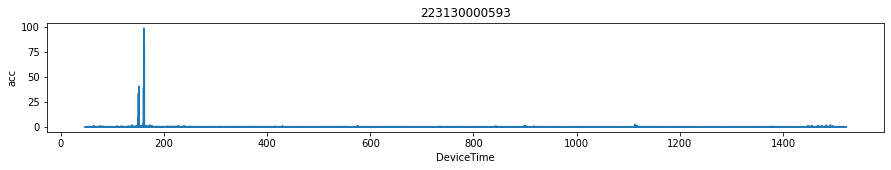

In [59]:
sig_df = pd.read_csv(data_loc + acc_file)
sig_df.rename(columns={"timestamp": "DeviceStamps"},inplace=True)
sig_df['DeviceTime'] = sig_df['DeviceStamps']/1000
sig_df.set_index('DeviceTime',inplace=True)
V = sig_df.loc[:,['x','y','z']].copy()
X=np.sqrt(np.square(V.diff()).sum(axis=1))
X.plot(figsize=(15,2))
plt.ylabel(sig)
plt.title(sensorID)
plt.show()

In [60]:
initial_offset = 149.5#149.5 408

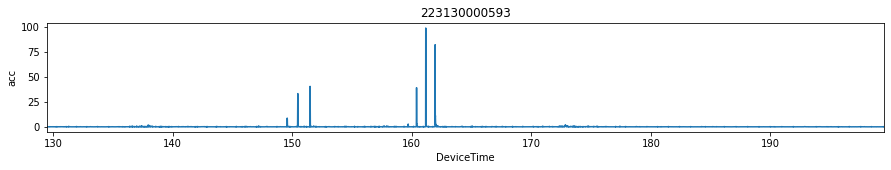

In [61]:
V = sig_df.loc[:,['x','y','z']].copy()
X=np.sqrt(np.square(V.diff()).sum(axis=1))
X.plot(figsize=(15,2))
plt.ylabel(sig)
plt.title(sensorID)
plt.xlim([initial_offset - 20,initial_offset + 50])
plt.show()

In [62]:
cues = Cue_template.copy()
cues['time_concert'] = cues.index
cues['DeviceTime'] = cues.index + initial_offset
cues.set_index('DeviceTime',inplace=True)

V = sig_df.loc[:,['x','y','z']].copy()
X=np.sqrt(np.square(V.diff()).sum(axis=1))
sig_ex = X.loc[cues.index[0]:cues.index[-1]]
print(len(sig_ex))
sig_ID = sensorID
cuetype = 'spoint'

f = interpolate.interp1d(cues.index, cues[cuetype],fill_value='extrapolate')
cued = pd.DataFrame(index = sig_ex.index,data = f(np.array(sig_ex.index)),columns = ['cue'])
f = interpolate.interp1d(cues.index, cues['time_concert'],fill_value='extrapolate')
cued['time_concert'] = f(np.array(sig_ex.index))
print(len(cued))

# cued.plot.line(y = 'cue')
# sig_ex.plot()
# plt.show()

3086
3086


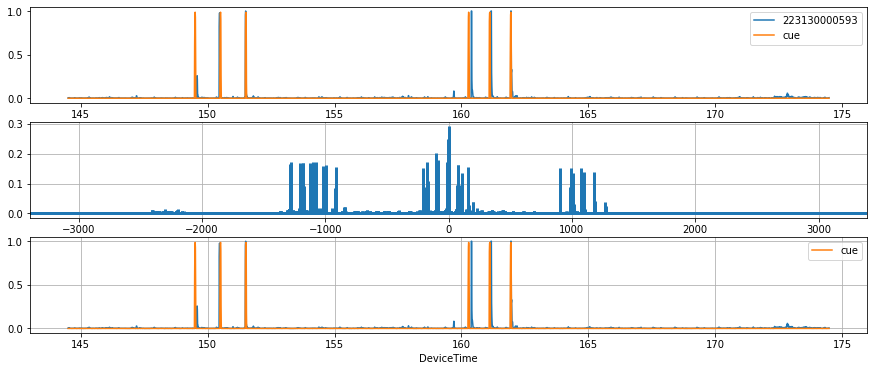

0.0

In [63]:
shifts = tap_cue_align(cued,sig_ex,sig_ID)
shifts['s_offset_time']

In [64]:
offset = initial_offset - np.round(shifts['s_offset_time'],3) # improved alignment of bigining of taps in device time
delay = np.round(offset-sig_df.index[0],3) # time after initial recording of the taps 
print([offset,delay])

[149.5, 102.268]


In [65]:
for f in sens_files['File']:
    sig_df = pd.read_csv(data_loc + f)
    if f.endswith('heartRate_stream.csv'):
        sig_df['RecTime'] = sig_df['rrData'].cumsum()/1000
        sig_df['ConcertTime'] = np.round(sig_df['RecTime'] - delay,3)
        sig_df.set_index('ConcertTime',inplace=True)
        sig_df.to_csv('./Day1/Timed/' + f)
    else:
        sig_df.rename(columns={"timestamp": "DeviceStamps"},inplace=True)
        sig_df['DeviceTime'] = sig_df['DeviceStamps']/1000
        sig_df['ConcertTime'] = np.round(sig_df['DeviceTime'] - offset,3)
        sig_df.set_index('ConcertTime',inplace=True)
        sig_df.to_csv('./Day1/Timed/' + f)
sig_df.iloc[:5,:]

,average,rrData,RecTime
ConcertTime,,,
-101.347,67.300000,921,0.921
-100.402,66.200005,945,1.866
-99.418,64.600000,984,2.850
-98.473,64.300000,945,3.795
-97.528,64.100000,945,4.740


# singers measurements

note: Kayla devices (223130000510, 223130000551) recorded from 2023-01-11 11:45:44, and caught synch taps on a delay of 257.185, or at 11:50:01

Jonna's device (223130000541) recorded from 2023-01-11 11:40:01 and caught taps on delay of 599.694 (10 minutes), rounding to 11:50:01 for synch cue taps.

This suggests iphones time can be used to sync to the second (ish) so we will use Kayla's delay on Day 1 to set the delay for the singer.

On day 1, Kayla's devices (223130000620, 223130000593) started recording at 2023-01-10 11:45:02 with 102.532, 102.268, seting the sync cue time at 11:46:44


Jonna's Phone's recording of the singer on device 223130000596 started at 2023-01-10 11:53:35

11:46:44 - 11:53:35 = -0:06:51 = -(360+51) = - 411 seconds "delay"

In [66]:
delay = - 411

In [67]:
data_loc = './Day1/Movesense_Singer_iPhone/'
sig = 'acc'
files = os.listdir(data_loc)
k = []
for f in files:
    if f.endswith('.csv'):
        c = f.split('_')
        st = dt.datetime.strptime(c[0][:-1],'%Y%m%dT%H%M%S')
        devID = int(c[1])
        fl = {'Signal':c[2],'StartTime':st,'daytime':int(c[0][9:15]),'date':int(c[0][:8]),'Device':devID,'File':f}
        k.append(fl)
df_files=pd.DataFrame(data=k).sort_values('StartTime').reset_index(drop=True)
df_files

,Signal,StartTime,daytime,date,Device,File
0,ecg,2023-01-10 11:53:35,115335,20230110,223130000596,20230110T115335Z_223130000596_ecg_stream.csv
1,acc,2023-01-10 11:53:35,115335,20230110,223130000596,20230110T115335Z_223130000596_acc_stream.csv
2,heartRate,2023-01-10 11:53:35,115335,20230110,223130000596,20230110T115335Z_223130000596_heartRate_stream...


In [68]:
sensorID =  223130000596
sens_files = df_files.loc[df_files['Device']==sensorID,:]
acc_file = sens_files.loc[sens_files['Signal']=='acc','File'].values[0]
print(acc_file)
sens_files

20230110T115335Z_223130000596_acc_stream.csv


,Signal,StartTime,daytime,date,Device,File
0,ecg,2023-01-10 11:53:35,115335,20230110,223130000596,20230110T115335Z_223130000596_ecg_stream.csv
1,acc,2023-01-10 11:53:35,115335,20230110,223130000596,20230110T115335Z_223130000596_acc_stream.csv
2,heartRate,2023-01-10 11:53:35,115335,20230110,223130000596,20230110T115335Z_223130000596_heartRate_stream...


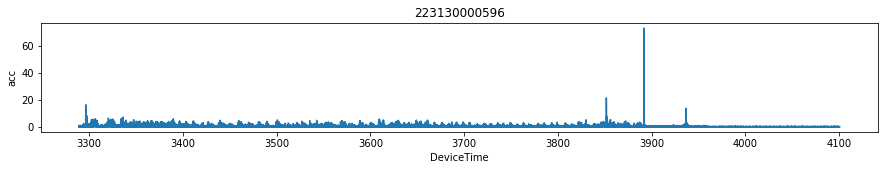

In [69]:
sig_df = pd.read_csv(data_loc + acc_file)
sig_df.rename(columns={"timestamp": "DeviceStamps"},inplace=True)
sig_df['DeviceTime'] = sig_df['DeviceStamps']/1000
sig_df.set_index('DeviceTime',inplace=True)
V = sig_df.loc[:,['x','y','z']].copy()
X=np.sqrt(np.square(V.diff()).sum(axis=1))
X.plot(figsize=(15,2))
plt.ylabel(sig)
plt.title(sensorID)
plt.show()

In [70]:
offset = sig_df.index[0] + delay
offset

2878.084

In [71]:
for f in sens_files['File']:
    sig_df = pd.read_csv(data_loc + f)
    if f.endswith('heartRate_stream.csv'):
        sig_df['RecTime'] = sig_df['rrData'].cumsum()/1000
        sig_df['ConcertTime'] = np.round(sig_df['RecTime'] - delay,3)
        sig_df.set_index('ConcertTime',inplace=True)
        sig_df.to_csv('./Day1/Timed/' + f)
    else:
        sig_df.rename(columns={"timestamp": "DeviceStamps"},inplace=True)
        sig_df['DeviceTime'] = sig_df['DeviceStamps']/1000
        sig_df['ConcertTime'] = np.round(sig_df['DeviceTime'] - offset,3)
        sig_df.set_index('ConcertTime',inplace=True)
        sig_df.to_csv('./Day1/Timed/' + f)
sig_df.iloc[:5,:]

,average,rrData,RecTime
ConcertTime,,,
411.616,98.600000,616,0.616
412.232,98.200005,616,1.232
412.848,98.000000,616,1.848
413.472,97.500000,624,2.472
414.112,96.400000,640,3.112


 Singer's data is aligned to the second. The rest shoudl be within 100 ms, or so.

# Delsys Day 1
Now to go back to delsys day 1 data to figure out how it got confused and produce some consistent alignment

In [73]:
path = './Day1/Delsys/'
file_locs = []
for root, dirs, files in os.walk(path):
    for file in files:
        if(file.lower().endswith(".csv")): # ignoring the json files for now, those are only from datalogger
            file_locs.append(os.path.join(root,file))

acc_locs = [x for x in file_locs if x.endswith('acc_stream.csv')] 
print(acc_locs)

acc_day = pd.DataFrame()
for file in acc_locs:
    sig_df = pd.read_csv(file,index_col=0)
    sensorID = file.split('_')[2]
    V = sig_df.loc[:,['x','y','z']].copy()
    X=np.sqrt(np.square(V.diff()).sum(axis=1))
    acc_day[sensorID] = X
acc_day.iloc[:5,:]

['./Day1/Delsys/Delsys_20230110T120000Z_Trignosensor1_acc_stream.csv', './Day1/Delsys/Delsys_20230110T120000Z_TrignoMinisensor8_acc_stream.csv', './Day1/Delsys/Delsys_20230110T120000Z_EKGsensor11_acc_stream.csv', './Day1/Delsys/Delsys_20230110T120000Z_TrignoMinisensor7_acc_stream.csv', './Day1/Delsys/Delsys_20230110T120000Z_TrignoMinisensor6_acc_stream.csv', './Day1/Delsys/Delsys_20230110T120000Z_TrignoMinisensor9_acc_stream.csv', './Day1/Delsys/Delsys_20230110T120000Z_EKGsensor12_acc_stream.csv', './Day1/Delsys/Delsys_20230110T120000Z_Trignosensor5_acc_stream.csv', './Day1/Delsys/Delsys_20230110T120000Z_EKGsensor14_acc_stream.csv', './Day1/Delsys/Delsys_20230110T120000Z_Trignosensor4_acc_stream.csv', './Day1/Delsys/Delsys_20230110T120000Z_EKGsensor13_acc_stream.csv', './Day1/Delsys/Delsys_20230110T120000Z_Trignosensor3_acc_stream.csv']


,Trignosensor1,TrignoMinisensor8,EKGsensor11,TrignoMinisensor7,TrignoMinisensor6,TrignoMinisensor9,EKGsensor12,Trignosensor5,EKGsensor14,Trignosensor4,EKGsensor13,Trignosensor3
0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
0.00675,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
0.01350,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
0.02025,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
0.02700,0.776743,0.817849,0.0,0.744539,0.765927,0.797394,0.0,1.256248,0.0,0.696023,0.0,1.892054


It looks like sensors "Trignosensor5" did not record the experiment properly.

<AxesSubplot:>

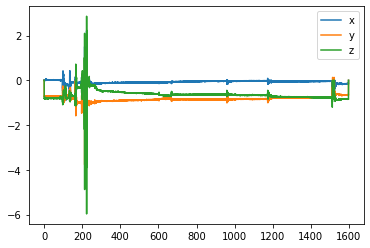

In [78]:
# first find tapping timing in one acc recording from delsys
file = acc_locs[8]
sig_df = pd.read_csv(file,index_col=0)
sensorID = file.split('_')[2]
sig_df.plot() 

In [79]:
initial_offset = 211.4 # approx offset of cue and signal 

4443
4443


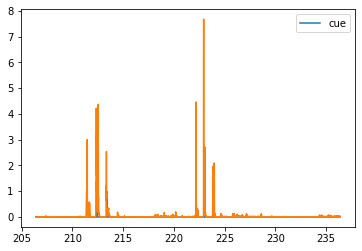

In [80]:
cues = Cue_template.copy()
cues['time_concert'] = cues.index
cues['DeviceTime'] = cues.index + initial_offset
cues.set_index('DeviceTime',inplace=True)

V = sig_df.loc[:,['x','y','z']].copy()
X=np.sqrt(np.square(V.diff()).sum(axis=1))
sig_ex = X.loc[cues.index[0]:cues.index[-1]]
print(len(sig_ex))
sig_ID = sensorID
cuetype = 'spoint'

f = interpolate.interp1d(cues.index, cues[cuetype],fill_value='extrapolate')
cued = pd.DataFrame(index = sig_ex.index,data = f(np.array(sig_ex.index)),columns = ['cue'])
f = interpolate.interp1d(cues.index, cues['time_concert'],fill_value='extrapolate')
cued['time_concert'] = f(np.array(sig_ex.index))
print(len(cued))

cued.plot.line(y = 'cue')
sig_ex.plot()
plt.show()

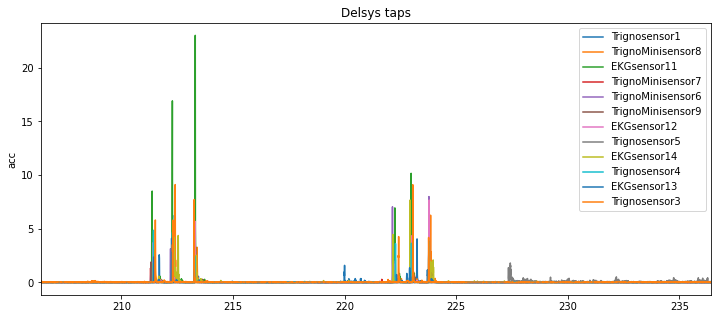

In [81]:
fig = plt.figure(figsize=(12,5))
acc_day = pd.DataFrame()
for file in acc_locs:
    sig_df = pd.read_csv(file,index_col=0)
    sensorID = file.split('_')[2]
    V = sig_df.loc[:,['x','y','z']].copy()
    X=np.sqrt(np.square(V.diff()).sum(axis=1))
    X.plot(label=sensorID)
    acc_day[sensorID] = X
plt.legend()
plt.ylabel('acc')
plt.title('Delsys taps')
#plt.ylim([0,1000])
plt.xlim([initial_offset -5 ,initial_offset + 25])
plt.show()

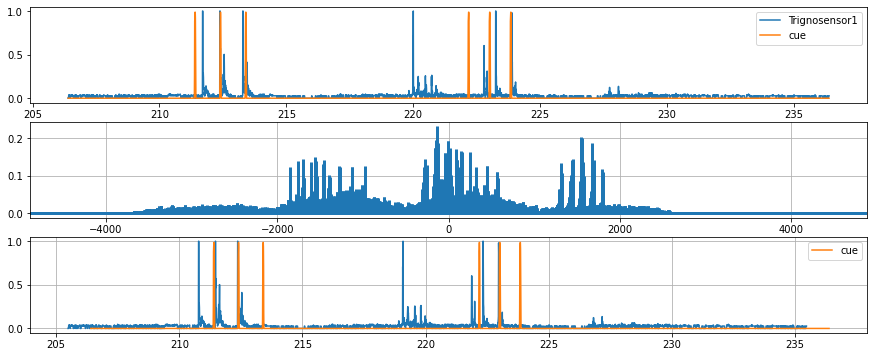

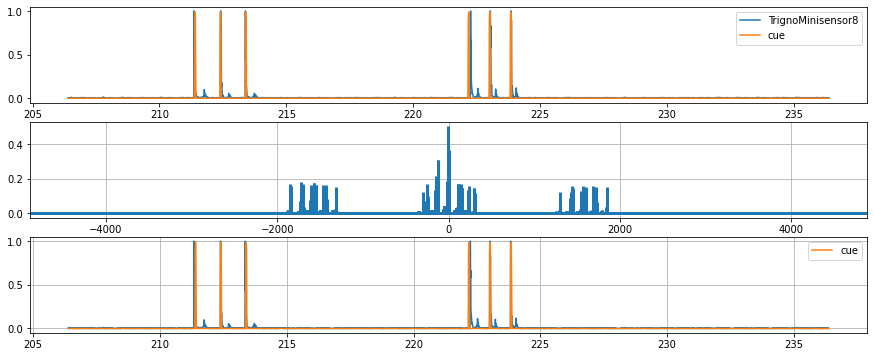

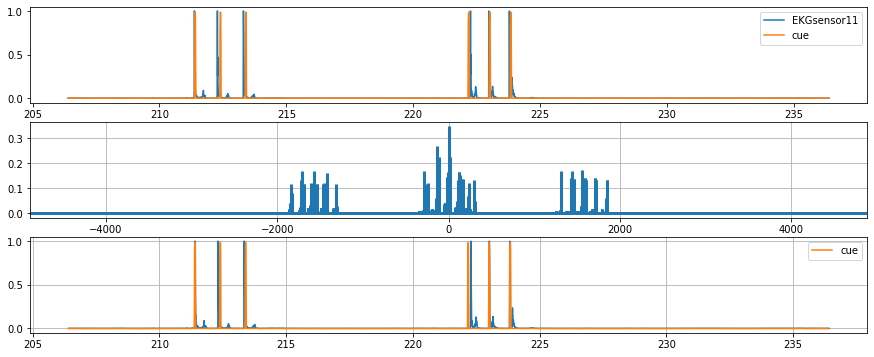

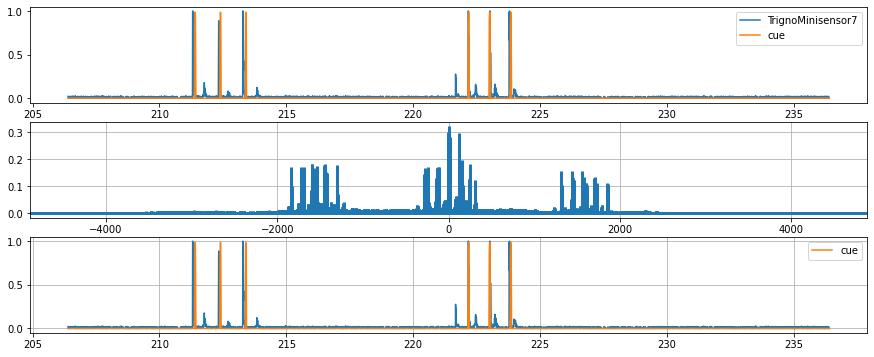

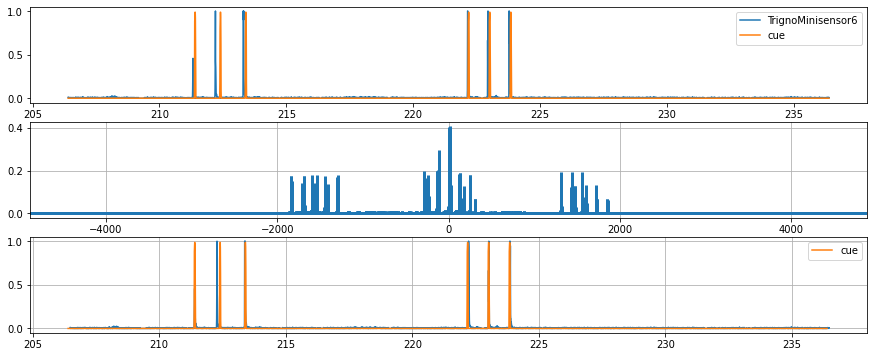

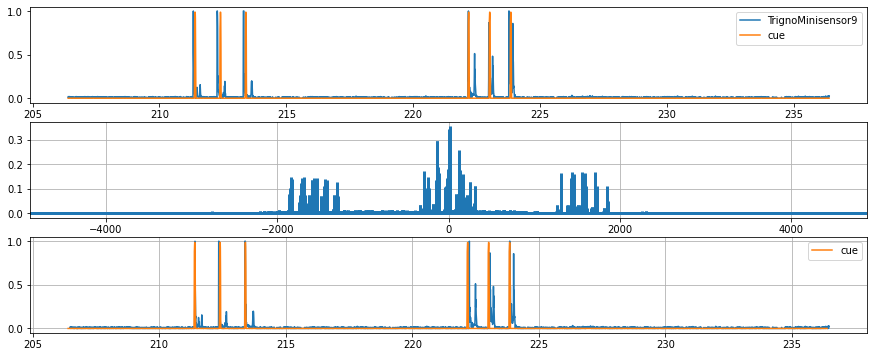

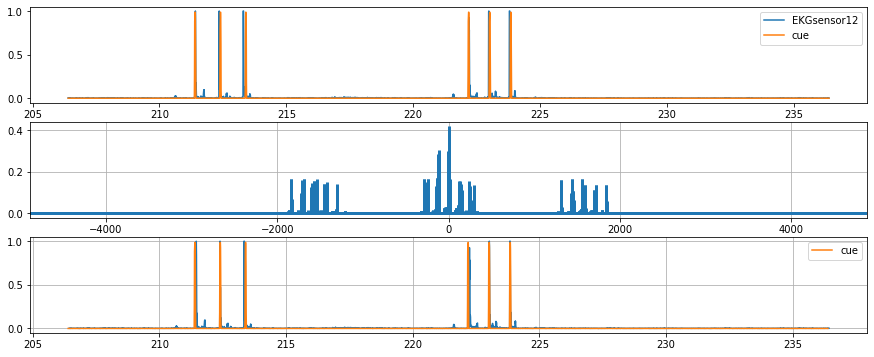

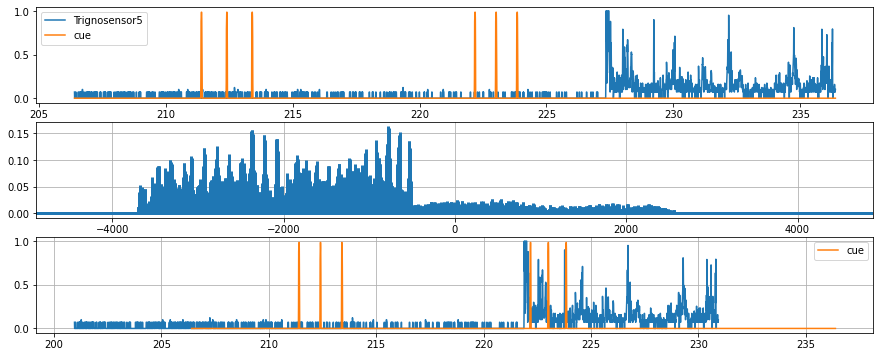

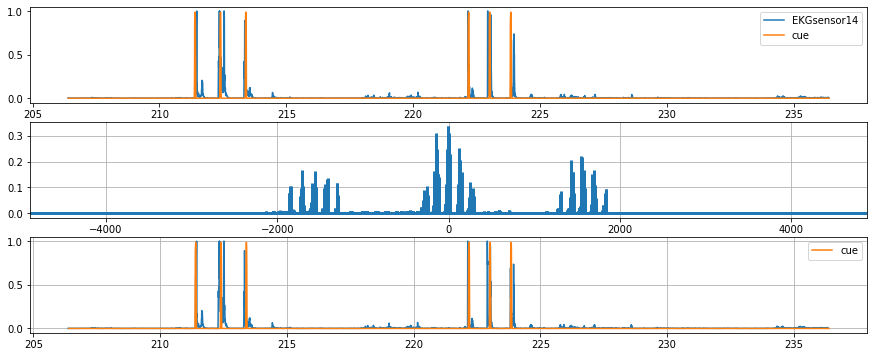

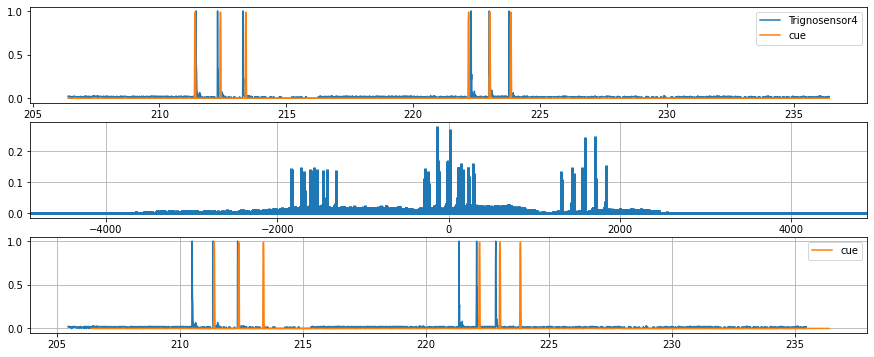

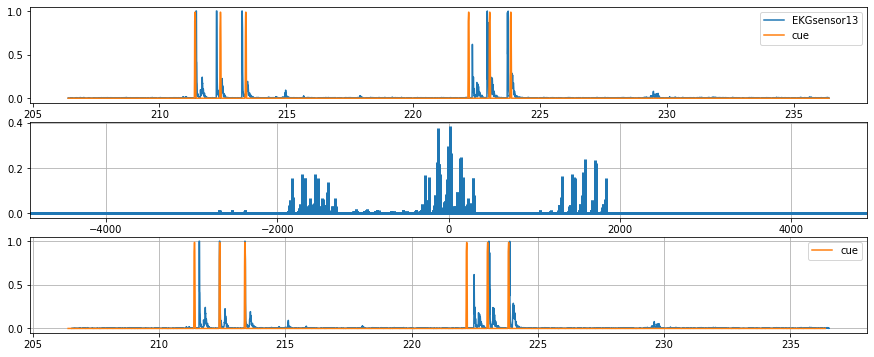

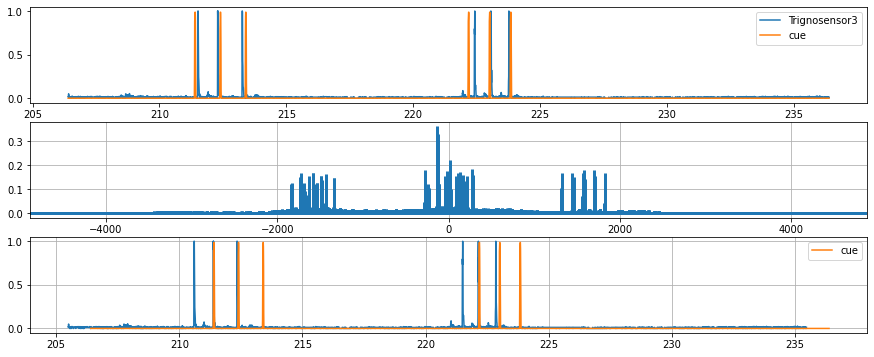

In [82]:
sig_exs = acc_day.loc[cued.index[0]:cued.index[-1]]
cols = sig_exs.columns
shifts = []
for c in cols:
    shifts.append(tap_cue_align(cued,sig_exs[c],c))

In [83]:
shift_df = pd.DataFrame.from_records(shifts)
print(shift_df['s_offset_time'].median())
shift_df.median()

-0.010500000000007503


s_corr0                    0.143936
s_corr_offset              0.351585
s_offset_samples          -1.500000
s_offset_time             -0.010500
Length_xcorr_samples    8885.000000
Length_xcorr_time         62.195000
index_offset              -0.010500
dtype: float64

Some individual responses are off by close to a full second, but the median looks good (-0.01 s) so we can work with this offset for all the measurements from day 1. 

In [84]:
V = acc_day.copy()
# V['DeviceTime'] = acc_day1.index
V.set_index(acc_day.index-initial_offset,inplace = True)
V.to_csv('./Day1/Timed/Delsys_acc_Day1.csv')



In [85]:
path = './Day1/Delsys/'
sig = 'ekg'
file_locs = []
for root, dirs, files in os.walk(path):
    for file in files:
        if(file.lower().endswith(".csv")): # ignoring the json files for now, those are only from datalogger
            file_locs.append(os.path.join(root,file))

sig_locs = [x for x in file_locs if x.endswith(sig + '_stream.csv')] 
sig_locs

['./Day1/Delsys/Delsys_20230110T120000Z_EKGsensor13_ekg_stream.csv',
 './Day1/Delsys/Delsys_20230110T120000Z_EKGsensor14_ekg_stream.csv',
 './Day1/Delsys/Delsys_20230110T120000Z_EKGsensor12_ekg_stream.csv',
 './Day1/Delsys/Delsys_20230110T120000Z_EKGsensor11_ekg_stream.csv']

In [87]:
file = sig_locs[3]#'./Day1/Delsys/Delsys_20230110T120000Z_Trignosensor1_acc_stream.csv'
sig_df = pd.read_csv(file,index_col=0)
sensorID = file.split('_')[2]
sig_df.iloc[:5]

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,ekg
0.000000,0.0
0.000794,0.0
0.001588,0.0
0.002382,0.0
0.003176,0.0


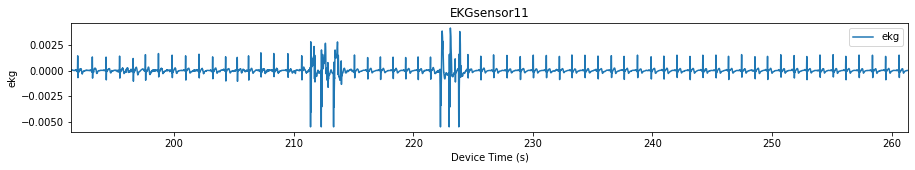

In [88]:
sig_df.plot(figsize=(15,2))
plt.ylabel(sig)
plt.title(sensorID)
#plt.ylim([0,1000])
plt.xlim([initial_offset - 20,initial_offset + 50])
plt.xlabel('Device Time (s)')
plt.show()

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


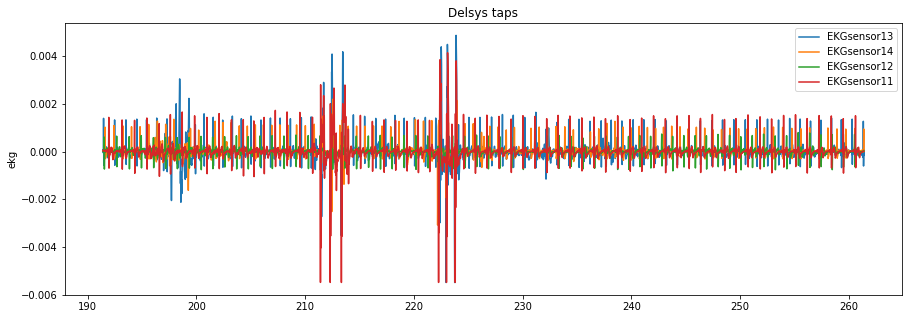

In [89]:
#fig = plt.figure()
sig_day = pd.DataFrame(index = sig_df.index)
for file in sig_locs:
    sig_df = pd.read_csv(file,index_col=0)
    sensorID = file.split('_')[2]
    sig_day[sensorID] = sig_df
sig_day.loc[(initial_offset - 20):(initial_offset + 50),:].plot(figsize=(15,5))
plt.legend()
plt.ylabel(sig)
plt.title('Delsys taps')
plt.show()

In [90]:
sig_day.iloc[:5,:]

,EKGsensor13,EKGsensor14,EKGsensor12,EKGsensor11
0.000000,0.0,0.0,0.0,0.0
0.000794,0.0,0.0,0.0,0.0
0.001588,0.0,0.0,0.0,0.0
0.002382,0.0,0.0,0.0,0.0
0.003176,0.0,0.0,0.0,0.0


In [91]:
V = sig_day.copy()
# V['DeviceTime'] = acc_day1.index
V.set_index(sig_day.index-initial_offset,inplace = True)
V.to_csv('./Day1/Timed/Delsys_ekg_Day1.csv')
V.iloc[:5,:]

,EKGsensor13,EKGsensor14,EKGsensor12,EKGsensor11
-211.400000,0.0,0.0,0.0,0.0
-211.399206,0.0,0.0,0.0,0.0
-211.398412,0.0,0.0,0.0,0.0
-211.397618,0.0,0.0,0.0,0.0
-211.396824,0.0,0.0,0.0,0.0


In [92]:
path = './Day1/Delsys/'
sig = 'emg'
file_locs = []
for root, dirs, files in os.walk(path):
    for file in files:
        if(file.lower().endswith(".csv")): # ignoring the json files for now, those are only from datalogger
            file_locs.append(os.path.join(root,file))

sig_locs = [x for x in file_locs if x.endswith(sig + '_stream.csv')] 
sig_locs


['./Day1/Delsys/Delsys_20230110T120000Z_TrignoMinisensor9_emg_stream.csv',
 './Day1/Delsys/Delsys_20230110T120000Z_TrignoMinisensor6_emg_stream.csv',
 './Day1/Delsys/Delsys_20230110T120000Z_TrignoMinisensor7_emg_stream.csv',
 './Day1/Delsys/Delsys_20230110T120000Z_TrignoMinisensor8_emg_stream.csv',
 './Day1/Delsys/Delsys_20230110T120000Z_Trignosensor1_emg_stream.csv',
 './Day1/Delsys/Delsys_20230110T120000Z_Trignosensor3_emg_stream.csv',
 './Day1/Delsys/Delsys_20230110T120000Z_Trignosensor4_emg_stream.csv',
 './Day1/Delsys/Delsys_20230110T120000Z_Trignosensor5_emg_stream.csv']

In [93]:
file = sig_locs[6]#'./Day1/Delsys/Delsys_20230110T120000Z_Trignosensor1_acc_stream.csv'
sig_df = pd.read_csv(file,index_col=0)
sensorID = file.split('_')[2]
sig_df.iloc[:5]

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,emg
0.000000,0.0
0.000519,0.0
0.001038,0.0
0.001558,0.0
0.002077,0.0


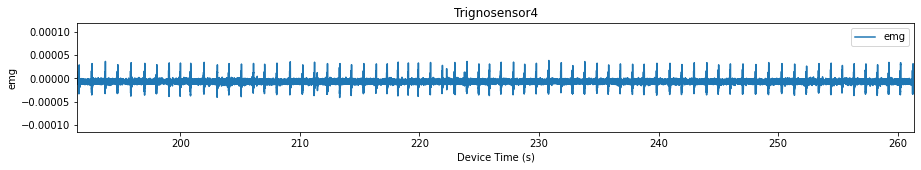

In [94]:
sig_df.plot(figsize=(15,2))
plt.ylabel(sig)
plt.title(sensorID)
#plt.ylim([0,1000])
plt.xlim([initial_offset - 20,initial_offset + 50])
plt.xlabel('Device Time (s)')
plt.show()

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


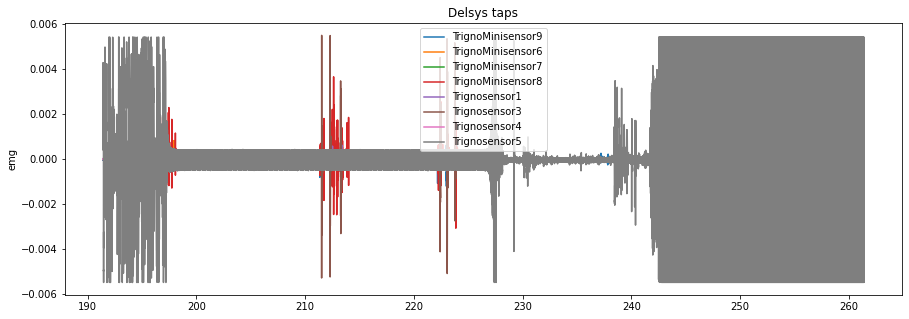

In [95]:
#fig = plt.figure()
sig_day = pd.DataFrame(index = sig_df.index)
for file in sig_locs:
    sig_df = pd.read_csv(file,index_col=0)
    sensorID = file.split('_')[2]
    sig_day[sensorID] = sig_df
sig_day.loc[(initial_offset - 20):(initial_offset + 50),:].plot(figsize=(15,5))
plt.legend()
plt.ylabel(sig)
plt.title('Delsys taps')
plt.show()

In [96]:
sig_day.iloc[:5,:]

,TrignoMinisensor9,TrignoMinisensor6,TrignoMinisensor7,TrignoMinisensor8,Trignosensor1,Trignosensor3,Trignosensor4,Trignosensor5
0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.000519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.001038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.001558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.002077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
V = sig_day.copy()
# V['DeviceTime'] = acc_day1.index
V.set_index(sig_day.index-initial_offset,inplace = True)
V.to_csv('./Day1/Timed/Delsys_emg_Day1.csv')
V.iloc[:5,:]

,TrignoMinisensor9,TrignoMinisensor6,TrignoMinisensor7,TrignoMinisensor8,Trignosensor1,Trignosensor3,Trignosensor4,Trignosensor5
-211.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-211.399481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-211.398962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-211.398442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-211.397923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# TODO
in another notebook: 
- cut the signals into matching measurements per the sections of the experiment
- output in multidevice csv per segment: 
    - resampled QoM recordings from whole audience
    - resampled cardiac waves
    - estimated heart rate
- output in single device csv:
    - extracted peak timings for RR analysis (HRV)